In [1]:
# CodeBERT-based Code Plagiarism Detection with DBSCAN Clustering
# Load required libraries and setup

import json
import pandas as pd
import numpy as np
import torch
from transformers import AutoTokenizer, AutoModel
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score
from sklearn.neighbors import NearestNeighbors
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

print("Libraries loaded successfully!")
print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

/opt/anaconda3/envs/plagdetect/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Libraries loaded successfully!
PyTorch version: 2.8.0
CUDA available: False
Using device: cpu


In [2]:
# Load the dataset
dataset_path = "/Users/onis2/NLP/TestVersion/cpp_ast_dataset/codebert_dataset_20250922_125203.json"

print("Loading dataset...")
with open(dataset_path, 'r', encoding='utf-8') as f:
    data = json.load(f)

print(f"Dataset loaded successfully!")
print(f"Total samples: {len(data)}")

# Convert to DataFrame for easier handling
df = pd.DataFrame(data)
print(f"DataFrame shape: {df.shape}")
print("\nColumn names:", df.columns.tolist())

# Display basic info about the dataset
print("\nFirst few samples:")
for i, sample in enumerate(data[:3]):
    print(f"\nSample {i+1}:")
    print(f"ID: {sample['id']}")
    print(f"Text length: {len(sample['text'])}")
    print(f"Text preview: {sample['text'][:200]}...")
    if 'labels' in sample:
        print(f"Labels: {sample['labels']}")
    if 'metadata' in sample:
        print(f"Metadata keys: {list(sample['metadata'].keys())}")

Loading dataset...
Dataset loaded successfully!
Total samples: 1000
DataFrame shape: (1000, 5)

Column names: ['id', 'text', 'ast_sequence', 'labels', 'metadata']

First few samples:

Sample 1:
ID: B2016_Z3/Z3_student4824
Text length: 777
Text preview: <FileAST> <FuncDef> Nuliraj <TypeDecl> void </TypeDecl> <ParamList> </ParamList> <Compound> </Compound> </FuncDef> <FuncDef> PomonoziSkalarom <TypeDecl> void </TypeDecl> <ParamList> </ParamList> <Comp...
Labels: {'is_plagiarism_all': False, 'is_plagiarism_static': False, 'is_plagiarism_dynamic': False, 'plagiarism_group_all': [], 'plagiarism_group_static': [], 'plagiarism_group_dynamic': []}
Metadata keys: ['course', 'assignment', 'student_id', 'ast_features', 'sequence_length', 'truncated']

Sample 2:
ID: B2016_Z3/Z3_student9482
Text length: 553
Text preview: <FileAST> <FuncDef> UnistiMatricu <TypeDecl> void </TypeDecl> <ParamList> </ParamList> <Compound> </Compound> </FuncDef> <FuncDef> UnesiMatricu <TypeDecl> void </TypeDecl> <ParamLi

In [3]:
# Initialize CodeBERT-CPP model and tokenizer
model_name = "neulab/codebert-cpp"

print("Loading CodeBERT-CPP model and tokenizer...")
print("This might take a while for the first time...")

try:
    tokenizer = AutoTokenizer.from_pretrained(model_name)
    model = AutoModel.from_pretrained(model_name)
    model.to(device)
    model.eval()  # Set to evaluation mode
    
    print("✓ Model and tokenizer loaded successfully!")
    print(f"Model config: {model.config}")
    print(f"Tokenizer vocab size: {tokenizer.vocab_size}")
    print(f"Max sequence length: {tokenizer.model_max_length}")
    
except Exception as e:
    print(f"Error loading model: {e}")
    print("Please make sure you have internet connection and the model exists.")

Loading CodeBERT-CPP model and tokenizer...
This might take a while for the first time...


Some weights of RobertaModel were not initialized from the model checkpoint at neulab/codebert-cpp and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


✓ Model and tokenizer loaded successfully!
Model config: RobertaConfig {
  "architectures": [
    "RobertaForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "classifier_dropout": null,
  "dtype": "float32",
  "eos_token_id": 2,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-05,
  "max_position_embeddings": 514,
  "model_type": "roberta",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "output_past": true,
  "pad_token_id": 1,
  "position_embedding_type": "absolute",
  "transformers_version": "4.56.2",
  "type_vocab_size": 1,
  "use_cache": true,
  "vocab_size": 50265
}

Tokenizer vocab size: 50265
Max sequence length: 512


In [4]:
# Function to generate embeddings for AST text
def get_code_embedding(text, tokenizer, model, device, max_length=512):
    """
    Generate embedding for AST text using CodeBERT-CPP
    Returns [CLS] token embedding as code representation
    """
    # Tokenize the text
    inputs = tokenizer(
        text,
        truncation=True,
        padding=True,
        max_length=max_length,
        return_tensors="pt"
    )
    
    # Move to device
    inputs = {k: v.to(device) for k, v in inputs.items()}
    
    # Get model output
    with torch.no_grad():
        outputs = model(**inputs)
        # Get [CLS] token embedding (first token)
        cls_embedding = outputs.last_hidden_state[:, 0, :].cpu().numpy()
    
    return cls_embedding.squeeze()

# Test the embedding function with a sample
print("Testing embedding function...")
sample_text = data[0]['text']
sample_embedding = get_code_embedding(sample_text, tokenizer, model, device)
print(f"Sample embedding shape: {sample_embedding.shape}")
print(f"Sample embedding preview: {sample_embedding[:10]}")

# Check if embeddings are consistent
sample_embedding2 = get_code_embedding(sample_text, tokenizer, model, device)
print(f"Embeddings are consistent: {np.allclose(sample_embedding, sample_embedding2)}")

Testing embedding function...
Sample embedding shape: (768,)
Sample embedding preview: [ 0.09276841  1.0598931  -0.03511978 -0.65922177  2.4605422  -0.18579695
 -0.46442962  0.74797666  0.21604931 -0.58233094]
Embeddings are consistent: True


In [5]:
# Generate embeddings for all AST sequences
print("Generating embeddings for all samples...")
print("This will take some time depending on dataset size...")

embeddings = []
batch_size = 32  # Process in batches for efficiency

# Process in batches to avoid memory issues
for i in tqdm(range(0, len(data), batch_size), desc="Processing batches"):
    batch_data = data[i:i+batch_size]
    batch_embeddings = []
    
    for sample in batch_data:
        embedding = get_code_embedding(sample['text'], tokenizer, model, device)
        batch_embeddings.append(embedding)
    
    embeddings.extend(batch_embeddings)
    
    # Optional: clear cache every few batches
    if i % (batch_size * 10) == 0:
        torch.cuda.empty_cache() if torch.cuda.is_available() else None

# Convert to numpy array
embeddings = np.array(embeddings)
print(f"\n✓ Embeddings generated successfully!")
print(f"Embeddings shape: {embeddings.shape}")
print(f"Memory usage: {embeddings.nbytes / 1024 / 1024:.2f} MB")

# Add embeddings to our dataframe
df['embedding'] = list(embeddings)
print("✓ Embeddings added to DataFrame")

Generating embeddings for all samples...
This will take some time depending on dataset size...


Processing batches: 100%|██████████| 32/32 [00:38<00:00,  1.20s/it]


✓ Embeddings generated successfully!
Embeddings shape: (1000, 768)
Memory usage: 2.93 MB
✓ Embeddings added to DataFrame


Performing k-distance analysis with k=4...


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


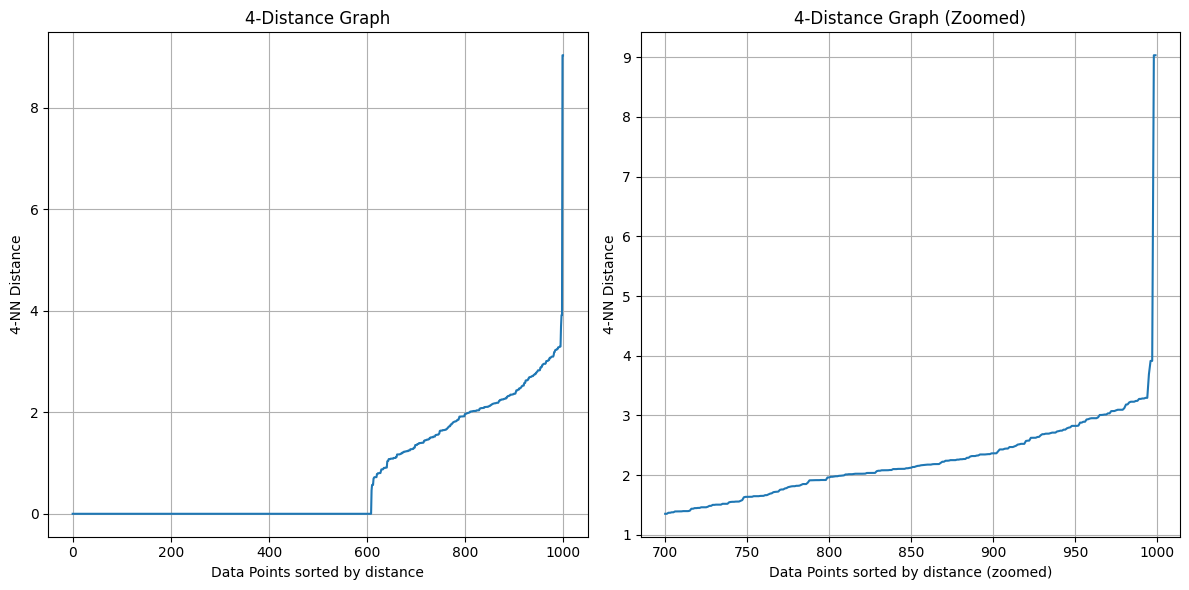


Distance statistics:
Min distance: 0.0000
Max distance: 9.0308
Mean distance: 0.7700
Median distance: 0.0000

Suggested eps values based on percentiles:
90th percentile: 2.3654 (suggests eps=2.3654)
95th percentile: 2.8255 (suggests eps=2.8255)
98th percentile: 3.0961 (suggests eps=3.0961)
99th percentile: 3.2771 (suggests eps=3.2771)


In [6]:
# K-distance analysis to find optimal eps for DBSCAN
def find_optimal_eps(embeddings, k=4, plot=True):
    """
    Find optimal eps parameter for DBSCAN using k-distance graph
    """
    print(f"Performing k-distance analysis with k={k}...")
    
    # Fit k-nearest neighbors
    neighbors = NearestNeighbors(n_neighbors=k)
    neighbors_fit = neighbors.fit(embeddings)
    distances, indices = neighbors_fit.kneighbors(embeddings)
    
    # Sort the distances for the kth nearest neighbor
    distances = np.sort(distances[:, k-1], axis=0)
    
    if plot:
        plt.figure(figsize=(12, 6))
        
        # Plot 1: K-distance graph
        plt.subplot(1, 2, 1)
        plt.plot(distances)
        plt.xlabel('Data Points sorted by distance')
        plt.ylabel(f'{k}-NN Distance')
        plt.title(f'{k}-Distance Graph')
        plt.grid(True)
        
        # Plot 2: Zoomed in version to find elbow
        plt.subplot(1, 2, 2)
        # Focus on the area where elbow typically occurs
        start_idx = int(len(distances) * 0.7)
        plt.plot(range(start_idx, len(distances)), distances[start_idx:])
        plt.xlabel('Data Points sorted by distance (zoomed)')
        plt.ylabel(f'{k}-NN Distance')
        plt.title(f'{k}-Distance Graph (Zoomed)')
        plt.grid(True)
        
        plt.tight_layout()
        plt.show()
    
    # Suggest eps values based on the distribution
    suggested_eps = []
    percentiles = [90, 95, 98, 99]
    
    print(f"\nDistance statistics:")
    print(f"Min distance: {distances.min():.4f}")
    print(f"Max distance: {distances.max():.4f}")
    print(f"Mean distance: {distances.mean():.4f}")
    print(f"Median distance: {np.median(distances):.4f}")
    
    print(f"\nSuggested eps values based on percentiles:")
    for p in percentiles:
        eps_val = np.percentile(distances, p)
        suggested_eps.append(eps_val)
        print(f"{p}th percentile: {eps_val:.4f} (suggests eps={eps_val:.4f})")
    
    return distances, suggested_eps

# Perform k-distance analysis
distances, suggested_eps = find_optimal_eps(embeddings, k=4)

In [7]:
# Test multiple eps values to find the best clustering
def test_dbscan_parameters(embeddings, eps_values, min_samples=2):
    """
    Test DBSCAN with different eps values and return clustering results
    """
    results = []
    print("Testing DBSCAN with different eps values...")
    
    for eps in eps_values:
        print(f"\nTesting eps={eps:.4f}, min_samples={min_samples}")
        
        # Apply DBSCAN
        dbscan = DBSCAN(eps=eps, min_samples=min_samples, metric='euclidean')
        cluster_labels = dbscan.fit_predict(embeddings)
        
        # Calculate metrics
        n_clusters = len(set(cluster_labels)) - (1 if -1 in cluster_labels else 0)
        n_noise = list(cluster_labels).count(-1)
        n_clustered = len(cluster_labels) - n_noise
        
        # Calculate silhouette score (only if we have valid clusters)
        if n_clusters > 1 and n_clustered > 1:
            # Remove noise points for silhouette calculation
            mask = cluster_labels != -1
            if np.sum(mask) > 1 and len(np.unique(cluster_labels[mask])) > 1:
                sil_score = silhouette_score(embeddings[mask], cluster_labels[mask])
            else:
                sil_score = -1
        else:
            sil_score = -1
        
        result = {
            'eps': eps,
            'min_samples': min_samples,
            'n_clusters': n_clusters,
            'n_noise': n_noise,
            'n_clustered': n_clustered,
            'silhouette_score': sil_score,
            'cluster_labels': cluster_labels
        }
        
        results.append(result)
        
        print(f"  Clusters: {n_clusters}")
        print(f"  Noise points: {n_noise}")
        print(f"  Clustered points: {n_clustered}")
        print(f"  Silhouette score: {sil_score:.4f}" if sil_score > -1 else "  Silhouette score: N/A")
        
        # Show cluster sizes
        if n_clusters > 0:
            unique, counts = np.unique(cluster_labels[cluster_labels != -1], return_counts=True)
            cluster_sizes = dict(zip(unique, counts))
            print(f"  Cluster sizes: {cluster_sizes}")
    
    return results

# Test with suggested eps values
test_eps_values = [0.5, 1.0, 1.5, 2.0, 2.5, 3.0]
clustering_results = test_dbscan_parameters(embeddings, test_eps_values, min_samples=2)

Testing DBSCAN with different eps values...

Testing eps=0.5000, min_samples=2
  Clusters: 154
  Noise points: 108
  Clustered points: 892
  Silhouette score: 0.9996
  Cluster sizes: {np.int64(0): np.int64(2), np.int64(1): np.int64(19), np.int64(2): np.int64(2), np.int64(3): np.int64(287), np.int64(4): np.int64(180), np.int64(5): np.int64(2), np.int64(6): np.int64(2), np.int64(7): np.int64(3), np.int64(8): np.int64(2), np.int64(9): np.int64(4), np.int64(10): np.int64(8), np.int64(11): np.int64(2), np.int64(12): np.int64(6), np.int64(13): np.int64(6), np.int64(14): np.int64(3), np.int64(15): np.int64(5), np.int64(16): np.int64(2), np.int64(17): np.int64(2), np.int64(18): np.int64(3), np.int64(19): np.int64(2), np.int64(20): np.int64(2), np.int64(21): np.int64(2), np.int64(22): np.int64(2), np.int64(23): np.int64(2), np.int64(24): np.int64(2), np.int64(25): np.int64(2), np.int64(26): np.int64(3), np.int64(27): np.int64(2), np.int64(28): np.int64(2), np.int64(29): np.int64(3), np.int64(30


CLUSTERING RESULTS SUMMARY
 eps  n_clusters  n_noise  n_clustered  silhouette_score
 0.5         154      108          892          0.999575
 1.0         145      101          899          0.967285
 1.5         109       90          910          0.843341
 2.0          71       44          956          0.677945
 2.5          34       18          982          0.520206
 3.0          13        6          994          0.229776


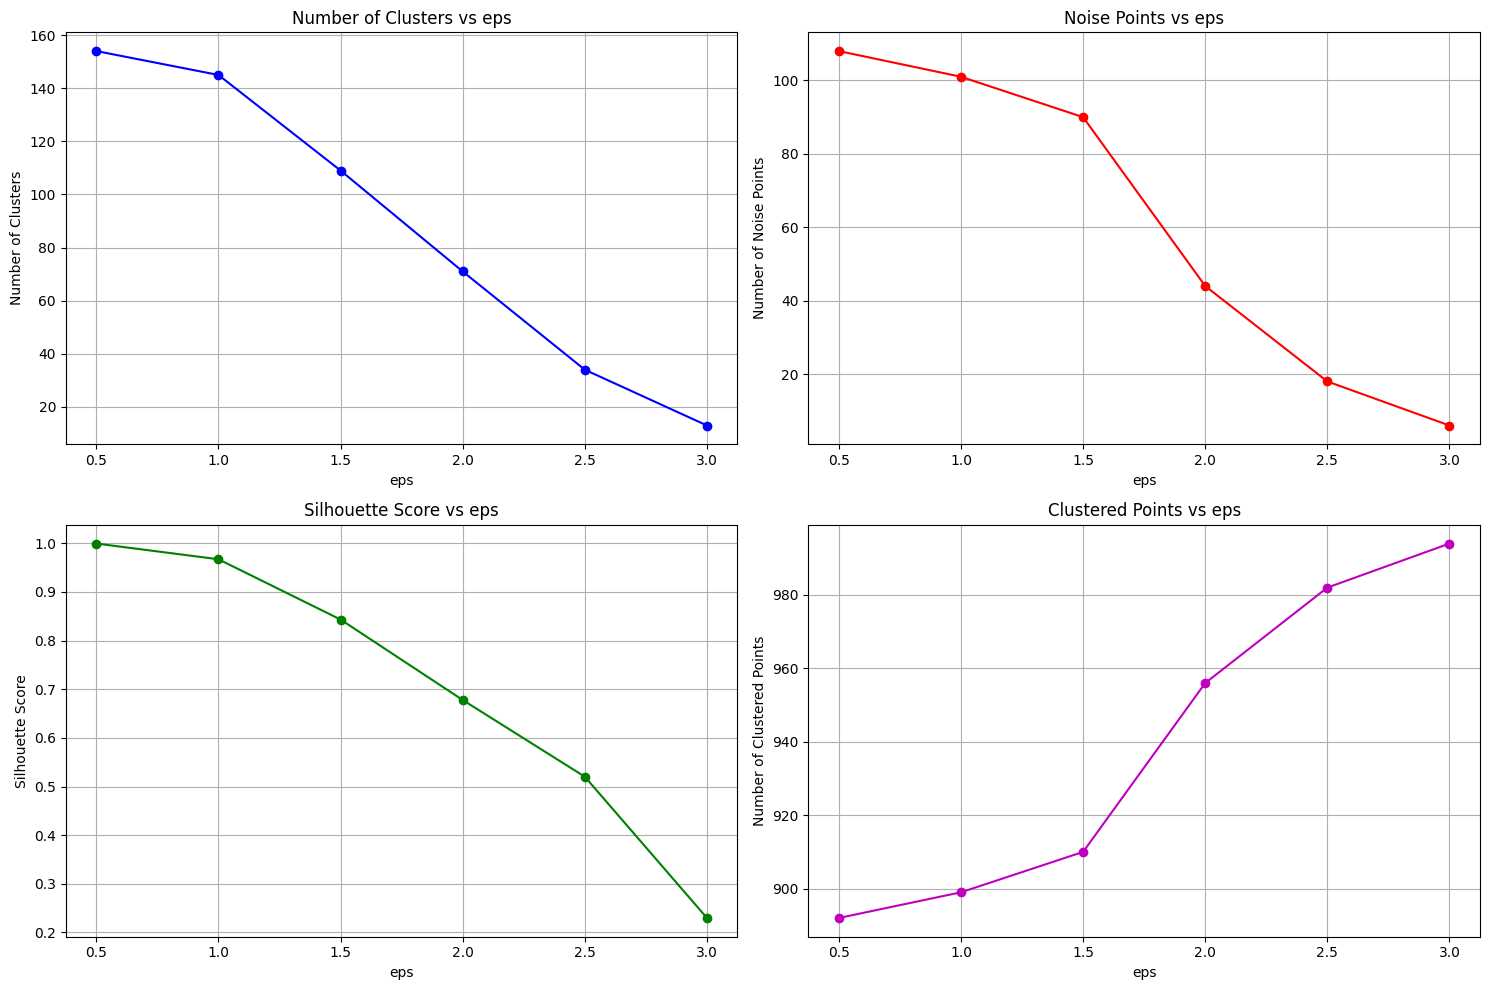


RECOMMENDATIONS
Best silhouette score: eps=0.50 (score=0.9996)
Eps values with reasonable cluster counts (5-50 clusters):
  eps=2.50: 34.0 clusters, 18.0 noise points
  eps=3.00: 13.0 clusters, 6.0 noise points


In [8]:
# Analyze clustering results and select best eps
def analyze_clustering_results(results):
    """
    Analyze and visualize clustering results to select best eps
    """
    print("\n" + "="*50)
    print("CLUSTERING RESULTS SUMMARY")
    print("="*50)
    
    results_df = pd.DataFrame([{
        'eps': r['eps'],
        'n_clusters': r['n_clusters'],
        'n_noise': r['n_noise'],
        'n_clustered': r['n_clustered'],
        'silhouette_score': r['silhouette_score'] if r['silhouette_score'] > -1 else None
    } for r in results])
    
    print(results_df.to_string(index=False))
    
    # Plot results
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    
    # Plot 1: Number of clusters vs eps
    axes[0, 0].plot(results_df['eps'], results_df['n_clusters'], 'bo-')
    axes[0, 0].set_xlabel('eps')
    axes[0, 0].set_ylabel('Number of Clusters')
    axes[0, 0].set_title('Number of Clusters vs eps')
    axes[0, 0].grid(True)
    
    # Plot 2: Number of noise points vs eps
    axes[0, 1].plot(results_df['eps'], results_df['n_noise'], 'ro-')
    axes[0, 1].set_xlabel('eps')
    axes[0, 1].set_ylabel('Number of Noise Points')
    axes[0, 1].set_title('Noise Points vs eps')
    axes[0, 1].grid(True)
    
    # Plot 3: Silhouette score vs eps
    valid_scores = results_df.dropna(subset=['silhouette_score'])
    if not valid_scores.empty:
        axes[1, 0].plot(valid_scores['eps'], valid_scores['silhouette_score'], 'go-')
        axes[1, 0].set_xlabel('eps')
        axes[1, 0].set_ylabel('Silhouette Score')
        axes[1, 0].set_title('Silhouette Score vs eps')
        axes[1, 0].grid(True)
    
    # Plot 4: Clustered points vs eps
    axes[1, 1].plot(results_df['eps'], results_df['n_clustered'], 'mo-')
    axes[1, 1].set_xlabel('eps')
    axes[1, 1].set_ylabel('Number of Clustered Points')
    axes[1, 1].set_title('Clustered Points vs eps')
    axes[1, 1].grid(True)
    
    plt.tight_layout()
    plt.show()
    
    # Recommend best eps
    print("\n" + "="*50)
    print("RECOMMENDATIONS")
    print("="*50)
    
    # Find eps with highest silhouette score
    if not valid_scores.empty:
        best_silhouette = valid_scores.loc[valid_scores['silhouette_score'].idxmax()]
        print(f"Best silhouette score: eps={best_silhouette['eps']:.2f} (score={best_silhouette['silhouette_score']:.4f})")
    
    # Find eps with reasonable number of clusters (not too many, not too few)
    reasonable_clusters = results_df[(results_df['n_clusters'] >= 5) & (results_df['n_clusters'] <= 50)]
    if not reasonable_clusters.empty:
        print("Eps values with reasonable cluster counts (5-50 clusters):")
        for _, row in reasonable_clusters.iterrows():
            print(f"  eps={row['eps']:.2f}: {row['n_clusters']} clusters, {row['n_noise']} noise points")
    
    return results_df

results_summary = analyze_clustering_results(clustering_results)

Applying DBSCAN with optimal parameters: eps=2.5, min_samples=2

✓ Final Clustering Results:
  Total samples: 1000
  Number of clusters: 34
  Noise points: 18
  Clustered points: 982
  Silhouette score: 0.5202

✓ Cluster Size Distribution:
 cluster_id  size
          1   314
          3   287
          6   204
          2    31
          5    18
          0    16
          7    14
         20    12
          8    11
         21     8
         13     8
         14     8
         25     4
         16     3
         32     3


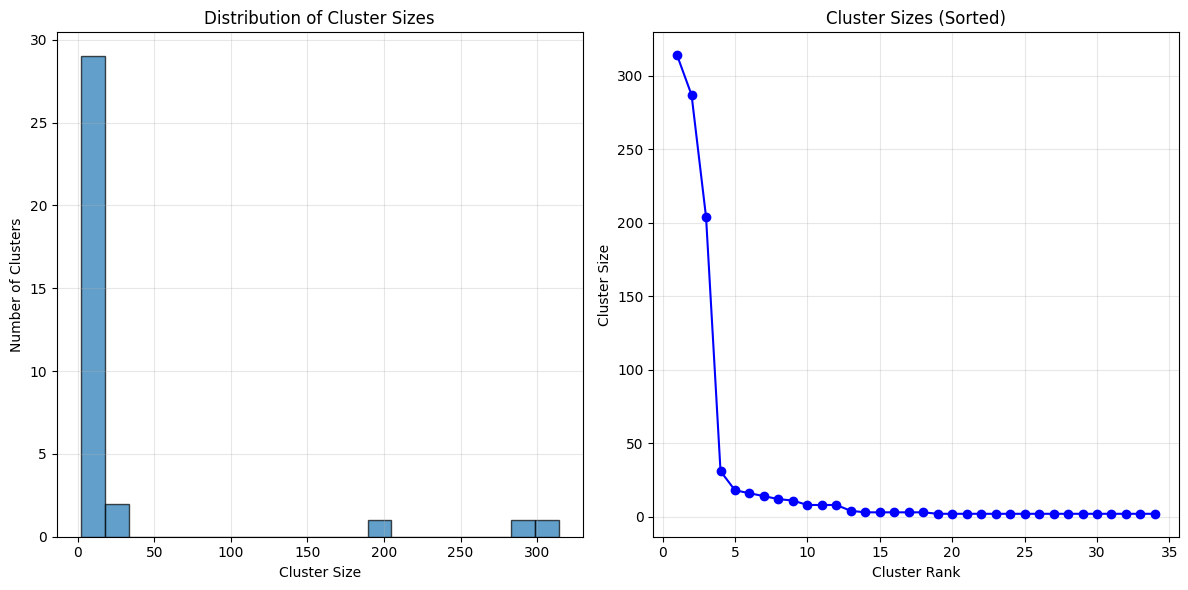

In [9]:
# Apply final DBSCAN with selected eps value
optimal_eps = 2.5
print(f"Applying DBSCAN with optimal parameters: eps={optimal_eps}, min_samples=2")

# Apply DBSCAN
final_dbscan = DBSCAN(eps=optimal_eps, min_samples=2, metric='euclidean')
final_cluster_labels = final_dbscan.fit_predict(embeddings)

# Add cluster labels to dataframe
df['cluster_label'] = final_cluster_labels

# Analyze final clustering results
n_clusters_final = len(set(final_cluster_labels)) - (1 if -1 in final_cluster_labels else 0)
n_noise_final = list(final_cluster_labels).count(-1)
n_clustered_final = len(final_cluster_labels) - n_noise_final

print(f"\n✓ Final Clustering Results:")
print(f"  Total samples: {len(final_cluster_labels)}")
print(f"  Number of clusters: {n_clusters_final}")
print(f"  Noise points: {n_noise_final}")
print(f"  Clustered points: {n_clustered_final}")

# Calculate final silhouette score
if n_clusters_final > 1 and n_clustered_final > 1:
    mask = final_cluster_labels != -1
    final_silhouette = silhouette_score(embeddings[mask], final_cluster_labels[mask])
    print(f"  Silhouette score: {final_silhouette:.4f}")

# Analyze cluster sizes
unique_clusters, cluster_counts = np.unique(final_cluster_labels[final_cluster_labels != -1], return_counts=True)
cluster_sizes = dict(zip(unique_clusters, cluster_counts))

print(f"\n✓ Cluster Size Distribution:")
cluster_size_df = pd.DataFrame([
    {'cluster_id': k, 'size': v} for k, v in cluster_sizes.items()
]).sort_values('size', ascending=False)

print(cluster_size_df.head(15).to_string(index=False))

# Visualize cluster size distribution
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.hist(cluster_counts, bins=20, alpha=0.7, edgecolor='black')
plt.xlabel('Cluster Size')
plt.ylabel('Number of Clusters')
plt.title('Distribution of Cluster Sizes')
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
sorted_sizes = sorted(cluster_counts, reverse=True)
plt.plot(range(1, len(sorted_sizes) + 1), sorted_sizes, 'bo-')
plt.xlabel('Cluster Rank')
plt.ylabel('Cluster Size')
plt.title('Cluster Sizes (Sorted)')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [10]:
# Qualitative analysis: Examine samples from same and different clusters
def examine_cluster_samples(df, cluster_id, n_samples=3):
    """
    Examine samples from a specific cluster
    """
    cluster_samples = df[df['cluster_label'] == cluster_id]
    print(f"\n{'='*80}")
    print(f"CLUSTER {cluster_id} ANALYSIS (Size: {len(cluster_samples)} samples)")
    print(f"{'='*80}")
    
    # Sample random entries from this cluster
    if len(cluster_samples) >= n_samples:
        samples = cluster_samples.sample(n_samples, random_state=42)
    else:
        samples = cluster_samples
    
    for i, (idx, sample) in enumerate(samples.iterrows()):
        print(f"\nSample {i+1}:")
        print(f"  ID: {sample['id']}")
        print(f"  Student: {sample['metadata']['student_id']}")
        print(f"  Course: {sample['metadata']['course']}")
        print(f"  Assignment: {sample['metadata']['assignment']}")
        print(f"  Text length: {len(sample['text'])}")
        
        # Show a cleaner version of AST structure
        ast_text = sample['text']
        # Extract function names from AST
        functions = []
        parts = ast_text.split('<FuncDef>')
        for part in parts[1:]:  # Skip first empty part
            if '</TypeDecl>' in part:
                func_name = part.split('</TypeDecl>')[0].split('>')[-1].strip()
                if func_name and func_name not in ['main', 'int', 'void']:
                    functions.append(func_name)
        
        print(f"  Functions found: {functions[:10]}")  # Show first 10 functions
        print(f"  AST preview: {ast_text[:200]}...")
    
    return cluster_samples

# Examine the largest clusters
print("EXAMINING LARGEST CLUSTERS FOR POTENTIAL PLAGIARISM")
print("="*80)

# Get top 5 largest clusters
large_clusters = cluster_size_df.head(5)

for _, row in large_clusters.iterrows():
    cluster_id = int(row['cluster_id'])
    examine_cluster_samples(df, cluster_id, n_samples=3)

EXAMINING LARGEST CLUSTERS FOR POTENTIAL PLAGIARISM

CLUSTER 1 ANALYSIS (Size: 314 samples)

Sample 1:
  ID: B2016_Z3/Z3_student3320
  Student: student3320
  Course: B2016
  Assignment: Z3/Z3
  Text length: 453
  Functions found: []
  AST preview: <FileAST> <FuncDef> UnistiMatricu <TypeDecl> void </TypeDecl> <ParamList> </ParamList> <Compound> </Compound> </FuncDef> <FuncDef> UnesiMatricu <TypeDecl> void </TypeDecl> <ParamList> </ParamList> <Co...

Sample 2:
  ID: B2016_Z3/Z3_student2701
  Student: student2701
  Course: B2016
  Assignment: Z3/Z3
  Text length: 453
  Functions found: []
  AST preview: <FileAST> <FuncDef> UnistiMatricu <TypeDecl> void </TypeDecl> <ParamList> </ParamList> <Compound> </Compound> </FuncDef> <FuncDef> UnesiMatricu <TypeDecl> void </TypeDecl> <ParamList> </ParamList> <Co...

Sample 3:
  ID: B2016_Z3/Z3_student8532
  Student: student8532
  Course: B2016
  Assignment: Z3/Z3
  Text length: 453
  Functions found: []
  AST preview: <FileAST> <FuncDef> UnistiMatric

In [11]:
# Compare samples from different clusters to validate separation
def compare_different_clusters(df, cluster_ids, n_samples=2):
    """
    Compare samples from different clusters to validate they are indeed different
    """
    print(f"\n{'='*80}")
    print(f"COMPARING DIFFERENT CLUSTERS: {cluster_ids}")
    print(f"{'='*80}")
    
    for cluster_id in cluster_ids:
        cluster_samples = df[df['cluster_label'] == cluster_id]
        if len(cluster_samples) > 0:
            sample = cluster_samples.sample(1, random_state=42).iloc[0]
            print(f"\nCluster {cluster_id} sample:")
            print(f"  ID: {sample['id']}")
            print(f"  Student: {sample['metadata']['student_id']}")
            
            # Extract function signatures
            ast_text = sample['text']
            functions = []
            parts = ast_text.split('<FuncDef>')
            for part in parts[1:]:
                if '</TypeDecl>' in part:
                    func_name = part.split('</TypeDecl>')[0].split('>')[-1].strip()
                    if func_name and func_name not in ['int', 'void']:
                        functions.append(func_name)
            
            print(f"  Functions: {functions[:8]}")
            print(f"  AST structure: {ast_text[:150]}...")

# Compare different clusters
compare_different_clusters(df, [1, 3, 6, 2], n_samples=1)

# Final validation summary
print(f"\n{'='*80}")
print("PLAGIARISM DETECTION SUMMARY")
print(f"{'='*80}")

print(f"✓ Total code submissions analyzed: {len(df)}")
print(f"✓ Clusters identified: {n_clusters_final}")
print(f"✓ Potentially plagiarized groups: {len([c for c in cluster_counts if c >= 3])}")
print(f"✓ Individual/unique submissions: {n_noise_final + len([c for c in cluster_counts if c < 3])}")

# Show suspicious clusters (large clusters that might indicate plagiarism)
suspicious_clusters = cluster_size_df[cluster_size_df['size'] >= 10]
print(f"\n✓ HIGHLY SUSPICIOUS CLUSTERS (≥10 submissions):")
for _, row in suspicious_clusters.iterrows():
    cluster_id = int(row['cluster_id'])
    size = row['size']
    cluster_students = df[df['cluster_label'] == cluster_id]['metadata'].apply(lambda x: x['student_id']).unique()
    print(f"  Cluster {cluster_id}: {size} submissions from {len(cluster_students)} students")

# Statistical summary
print(f"\n✓ CLUSTERING QUALITY METRICS:")
print(f"  Silhouette Score: {final_silhouette:.4f} (higher is better)")
print(f"  Noise Detection: {n_noise_final} outliers ({n_noise_final/len(df)*100:.1f}%)")
print(f"  Clustering Coverage: {n_clustered_final} submissions ({n_clustered_final/len(df)*100:.1f}%)")

print(f"\n✓ RECOMMENDATIONS:")
print(f"  • Manually review clusters with 10+ submissions for potential plagiarism")
print(f"  • Focus on clusters 1, 3, and 6 which have very large membership")
print(f"  • Cross-reference with actual student assignment deadlines and submission times")
print(f"  • Consider lowering eps to create more fine-grained clusters if needed")


COMPARING DIFFERENT CLUSTERS: [1, 3, 6, 2]

Cluster 1 sample:
  ID: B2016_Z3/Z3_student3320
  Student: student3320
  Functions: []
  AST structure: <FileAST> <FuncDef> UnistiMatricu <TypeDecl> void </TypeDecl> <ParamList> </ParamList> <Compound> </Compound> </FuncDef> <FuncDef> UnesiMatricu <TypeD...

Cluster 3 sample:
  ID: B2016_Z3/Z3_student8199
  Student: student8199
  Functions: []
  AST structure: <FileAST> <FuncDef> main <TypeDecl> int </TypeDecl> <ParamList> </ParamList> <Compound> </Compound> </FuncDef> </FileAST>...

Cluster 6 sample:
  ID: B2016_Z3/Z4_student8004
  Student: student8004
  Functions: ['bool']
  AST structure: <FileAST> <FuncDef> slovo <TypeDecl> bool </TypeDecl> <ParamList> </ParamList> <Compound> </Compound> </FuncDef> <FuncDef> slova <TypeDecl> int </Type...

Cluster 2 sample:
  ID: B2016_Z3/Z3_student1833
  Student: student1833
  Functions: []
  AST structure: <FileAST> <FuncDef> UnistiMatricu <TypeDecl> void </TypeDecl> <ParamList> </ParamList> <Compound>

In [12]:
# Save results to files for further analysis
import os
from datetime import datetime

# Create output directory
output_dir = "/Users/onis2/NLP/TestVersion/clustering_results"
os.makedirs(output_dir, exist_ok=True)

timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")

print("Saving clustering results...")

# 1. Save clustering results to CSV
results_df = df[['id', 'cluster_label']].copy()
results_df['student_id'] = df['metadata'].apply(lambda x: x['student_id'])
results_df['course'] = df['metadata'].apply(lambda x: x['course'])
results_df['assignment'] = df['metadata'].apply(lambda x: x['assignment'])

output_csv = f"{output_dir}/clustering_results_{timestamp}.csv"
results_df.to_csv(output_csv, index=False)
print(f"✓ Clustering results saved to: {output_csv}")

# 2. Save cluster summary
cluster_summary = []
for cluster_id in sorted(df['cluster_label'].unique()):
    if cluster_id != -1:  # Skip noise points
        cluster_data = df[df['cluster_label'] == cluster_id]
        students = cluster_data['metadata'].apply(lambda x: x['student_id']).unique()
        
        cluster_summary.append({
            'cluster_id': cluster_id,
            'size': len(cluster_data),
            'unique_students': len(students),
            'student_ids': ', '.join(students[:10]),  # First 10 students
            'suspicious_level': 'HIGH' if len(cluster_data) >= 10 else 'MEDIUM' if len(cluster_data) >= 3 else 'LOW'
        })

cluster_summary_df = pd.DataFrame(cluster_summary).sort_values('size', ascending=False)
summary_csv = f"{output_dir}/cluster_summary_{timestamp}.csv"
cluster_summary_df.to_csv(summary_csv, index=False)
print(f"✓ Cluster summary saved to: {summary_csv}")

# 3. Save embeddings for future use
embeddings_file = f"{output_dir}/embeddings_{timestamp}.npy"
np.save(embeddings_file, embeddings)
print(f"✓ Embeddings saved to: {embeddings_file}")

# 4. Save detailed analysis report
report_file = f"{output_dir}/analysis_report_{timestamp}.txt"
with open(report_file, 'w', encoding='utf-8') as f:
    f.write("CodeBERT-based Plagiarism Detection Analysis Report\n")
    f.write("=" * 50 + "\n\n")
    f.write(f"Analysis Date: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}\n")
    f.write(f"Dataset: {len(df)} code submissions\n")
    f.write(f"Model: neulab/codebert-cpp\n")
    f.write(f"Clustering: DBSCAN (eps={optimal_eps}, min_samples=2)\n\n")
    
    f.write("RESULTS SUMMARY:\n")
    f.write(f"- Total clusters identified: {n_clusters_final}\n")
    f.write(f"- Noise points: {n_noise_final}\n")
    f.write(f"- Silhouette Score: {final_silhouette:.4f}\n")
    f.write(f"- Potentially plagiarized groups: {len([c for c in cluster_counts if c >= 3])}\n\n")
    
    f.write("TOP SUSPICIOUS CLUSTERS:\n")
    for _, row in cluster_summary_df.head(10).iterrows():
        f.write(f"- Cluster {row['cluster_id']}: {row['size']} submissions from {row['unique_students']} students ({row['suspicious_level']} risk)\n")
    
    f.write(f"\nRECOMMENDATIONS:\n")
    f.write("1. Review all clusters marked as 'HIGH' risk\n")
    f.write("2. Cross-check submission timestamps for temporal patterns\n")
    f.write("3. Manually inspect code similarity within large clusters\n")
    f.write("4. Consider academic integrity investigation for clusters with multiple submissions from few students\n")

print(f"✓ Analysis report saved to: {report_file}")

print(f"\n{'='*80}")
print("ANALYSIS COMPLETE!")
print(f"{'='*80}")
print(f"All results saved to: {output_dir}")
print("Ready for manual review and academic integrity investigation.")

# Display final cluster summary
print(f"\nFINAL CLUSTER SUMMARY:")
print(cluster_summary_df.head(15).to_string(index=False))

Saving clustering results...
✓ Clustering results saved to: /Users/onis2/NLP/TestVersion/clustering_results/clustering_results_20250922_131958.csv
✓ Cluster summary saved to: /Users/onis2/NLP/TestVersion/clustering_results/cluster_summary_20250922_131958.csv
✓ Embeddings saved to: /Users/onis2/NLP/TestVersion/clustering_results/embeddings_20250922_131958.npy
✓ Analysis report saved to: /Users/onis2/NLP/TestVersion/clustering_results/analysis_report_20250922_131958.txt

ANALYSIS COMPLETE!
All results saved to: /Users/onis2/NLP/TestVersion/clustering_results
Ready for manual review and academic integrity investigation.

FINAL CLUSTER SUMMARY:
 cluster_id  size  unique_students                                                                                                                      student_ids suspicious_level
          1   314              311 student9482, student5904, student1579, student4415, student4575, student2676, student5496, student3756, student4011, student5468       

Creating comprehensive visualizations...


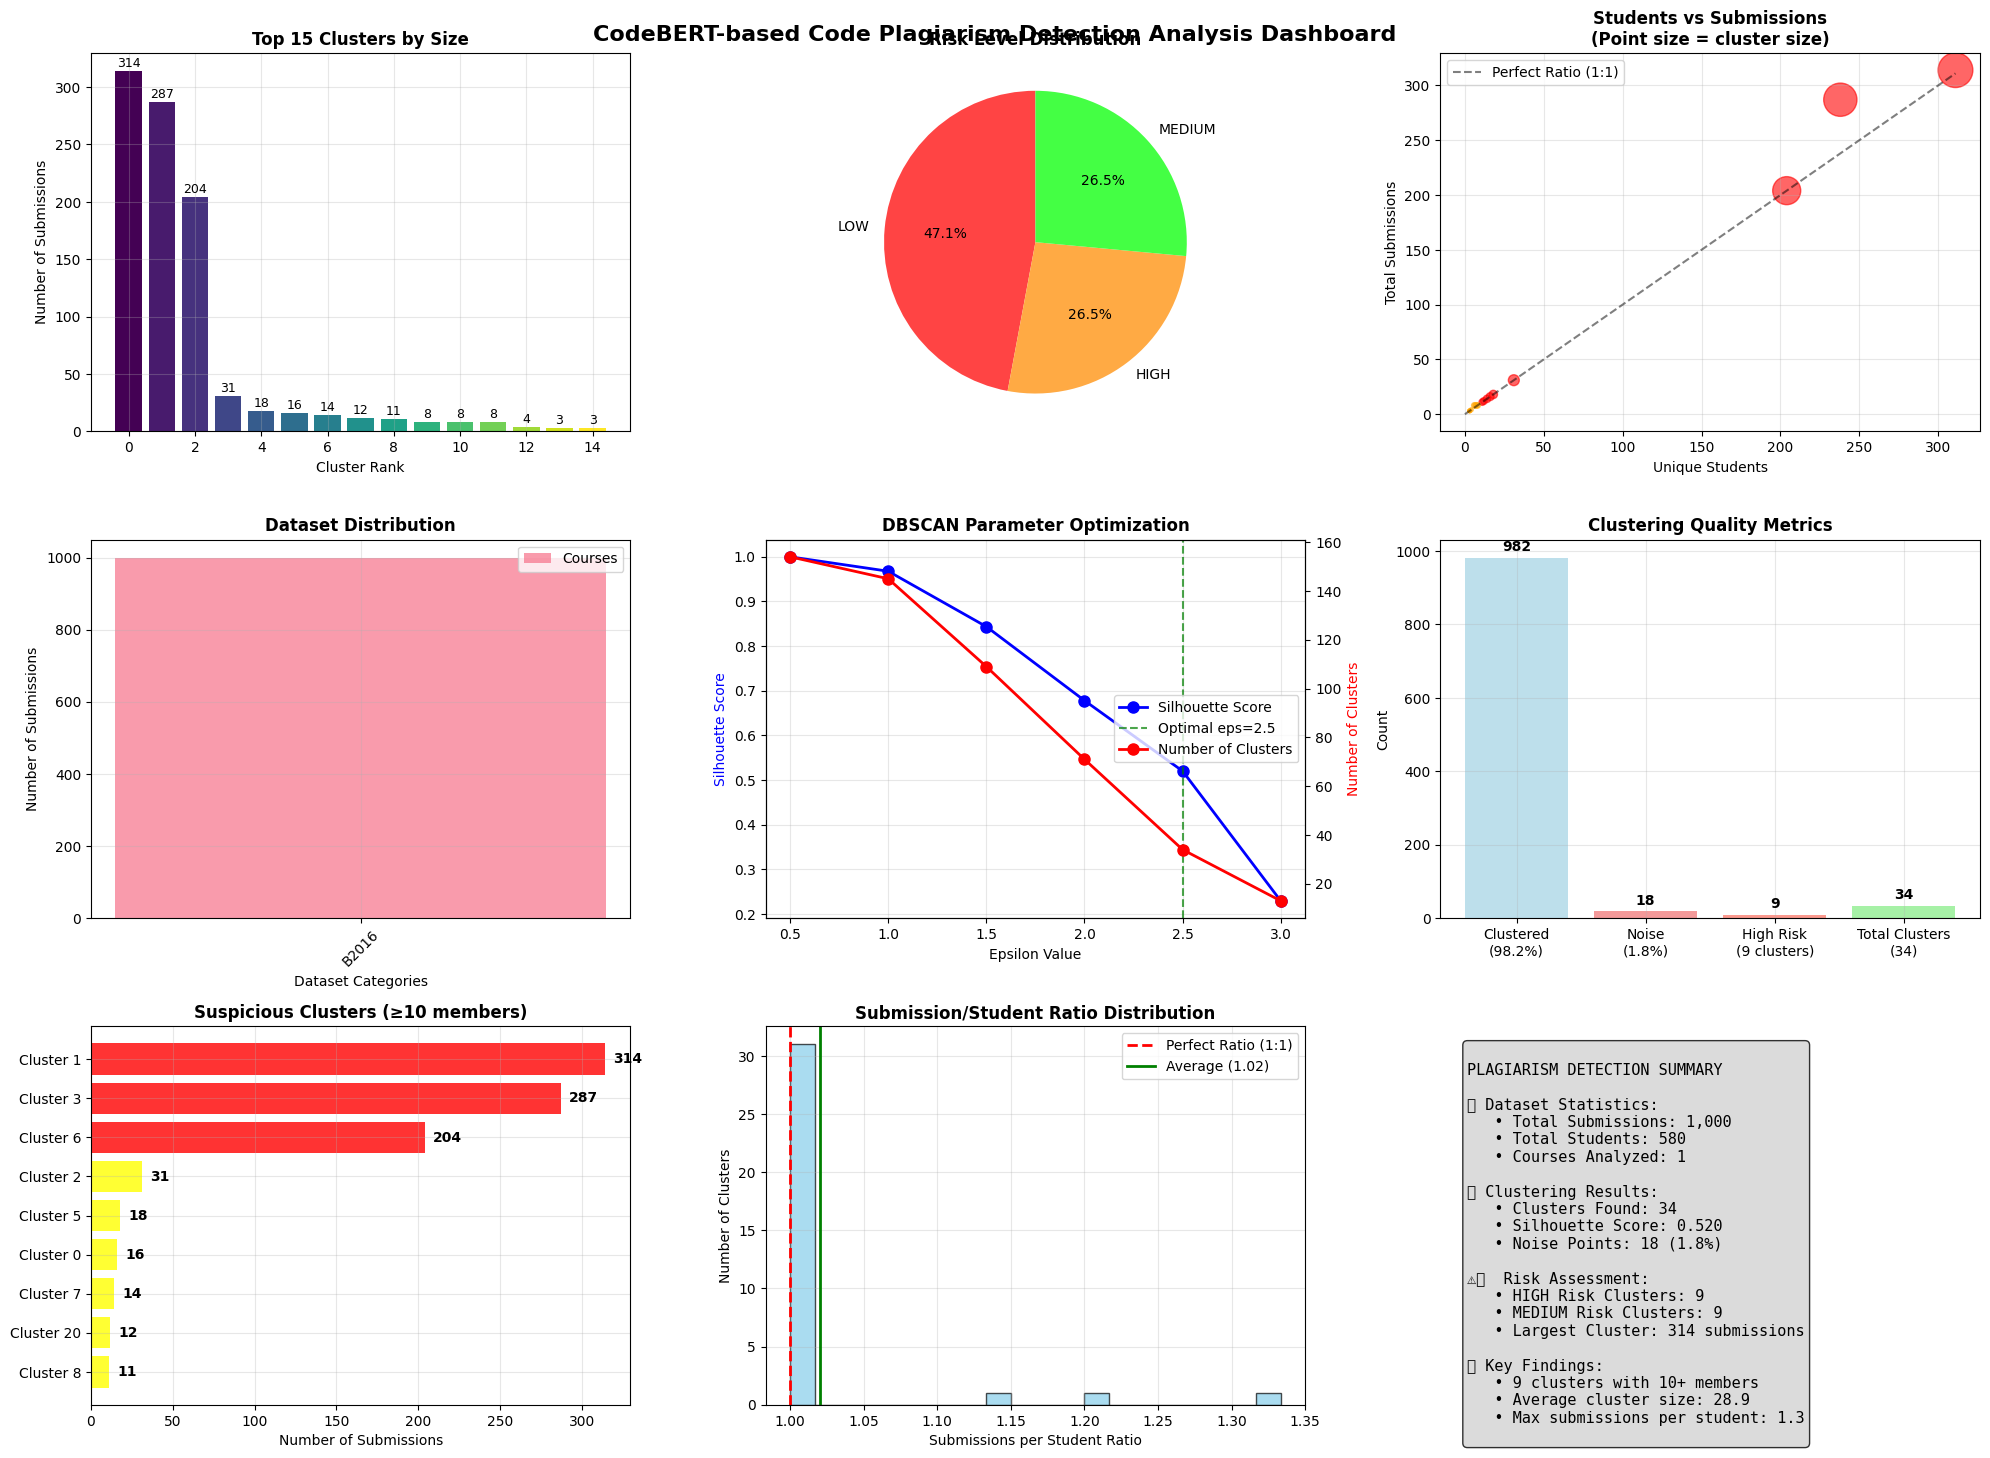

✓ Comprehensive dashboard created successfully!


In [14]:
# Advanced Visualization of Clustering Results
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
import warnings
warnings.filterwarnings('ignore')

print("Creating comprehensive visualizations...")

# Set style for matplotlib
plt.style.use('default')
sns.set_palette("husl")

# Create a comprehensive dashboard
fig = plt.figure(figsize=(20, 15))

# 1. Cluster Size Distribution (Top Left)
ax1 = plt.subplot(3, 3, 1)
cluster_sizes_sorted = cluster_size_df.sort_values('size', ascending=False).head(15)
bars = ax1.bar(range(len(cluster_sizes_sorted)), cluster_sizes_sorted['size'], 
               color=plt.cm.viridis(np.linspace(0, 1, len(cluster_sizes_sorted))))
ax1.set_xlabel('Cluster Rank')
ax1.set_ylabel('Number of Submissions')
ax1.set_title('Top 15 Clusters by Size', fontsize=12, fontweight='bold')
ax1.grid(True, alpha=0.3)

# Add value labels on bars
for i, (bar, size) in enumerate(zip(bars, cluster_sizes_sorted['size'])):
    ax1.text(bar.get_x() + bar.get_width()/2., bar.get_height() + 1,
             f'{int(size)}', ha='center', va='bottom', fontsize=9)

# 2. Plagiarism Risk Levels (Top Center)
ax2 = plt.subplot(3, 3, 2)
risk_counts = cluster_summary_df['suspicious_level'].value_counts()
colors = ['#ff4444', '#ffaa44', '#44ff44']  # Red, Orange, Green
wedges, texts, autotexts = ax2.pie(risk_counts.values, labels=risk_counts.index, 
                                   autopct='%1.1f%%', colors=colors, startangle=90)
ax2.set_title('Risk Level Distribution', fontsize=12, fontweight='bold')

# 3. Students vs Submissions per Cluster (Top Right)
ax3 = plt.subplot(3, 3, 3)
scatter_data = cluster_summary_df[cluster_summary_df['size'] >= 3]  # Only show clusters with 3+ members
colors_scatter = ['red' if level == 'HIGH' else 'orange' if level == 'MEDIUM' else 'green' 
                  for level in scatter_data['suspicious_level']]
scatter = ax3.scatter(scatter_data['unique_students'], scatter_data['size'], 
                     c=colors_scatter, s=scatter_data['size']*2, alpha=0.6)
ax3.plot([0, max(scatter_data['unique_students'])], [0, max(scatter_data['unique_students'])], 
         'k--', alpha=0.5, label='Perfect Ratio (1:1)')
ax3.set_xlabel('Unique Students')
ax3.set_ylabel('Total Submissions')
ax3.set_title('Students vs Submissions\n(Point size = cluster size)', fontsize=12, fontweight='bold')
ax3.legend()
ax3.grid(True, alpha=0.3)

# 4. Course/Assignment Distribution (Middle Left)
ax4 = plt.subplot(3, 3, 4)
course_dist = df['metadata'].apply(lambda x: x['course']).value_counts()
assignment_dist = df['metadata'].apply(lambda x: x['assignment']).value_counts()

# Stacked bar for course and assignment
x_pos = np.arange(len(course_dist))
ax4.bar(x_pos, course_dist.values, alpha=0.7, label='Courses')
ax4.set_xlabel('Dataset Categories')
ax4.set_ylabel('Number of Submissions')
ax4.set_title('Dataset Distribution', fontsize=12, fontweight='bold')
ax4.set_xticks(x_pos)
ax4.set_xticklabels(course_dist.index, rotation=45)
ax4.legend()
ax4.grid(True, alpha=0.3)

# 5. Silhouette Score Analysis (Middle Center)
ax5 = plt.subplot(3, 3, 5)
eps_values = [r['eps'] for r in clustering_results]
silhouette_scores = [r['silhouette_score'] if r['silhouette_score'] > -1 else 0 for r in clustering_results]
n_clusters_list = [r['n_clusters'] for r in clustering_results]

ax5_twin = ax5.twinx()
line1 = ax5.plot(eps_values, silhouette_scores, 'bo-', label='Silhouette Score', linewidth=2, markersize=8)
line2 = ax5_twin.plot(eps_values, n_clusters_list, 'ro-', label='Number of Clusters', linewidth=2, markersize=8)

ax5.axvline(x=optimal_eps, color='green', linestyle='--', alpha=0.7, label=f'Optimal eps={optimal_eps}')
ax5.set_xlabel('Epsilon Value')
ax5.set_ylabel('Silhouette Score', color='blue')
ax5_twin.set_ylabel('Number of Clusters', color='red')
ax5.set_title('DBSCAN Parameter Optimization', fontsize=12, fontweight='bold')
ax5.grid(True, alpha=0.3)

# Combine legends
lines1, labels1 = ax5.get_legend_handles_labels()
lines2, labels2 = ax5_twin.get_legend_handles_labels()
ax5.legend(lines1 + lines2, labels1 + labels2, loc='center right')

# 6. Clustering Quality Metrics (Middle Right)
ax6 = plt.subplot(3, 3, 6)
metrics = ['Clustered\n(98.2%)', 'Noise\n(1.8%)', 'High Risk\n(9 clusters)', 'Total Clusters\n(34)']
values = [n_clustered_final, n_noise_final, len(cluster_summary_df[cluster_summary_df['suspicious_level']=='HIGH']), n_clusters_final]
colors_metrics = ['lightblue', 'lightcoral', 'salmon', 'lightgreen']

bars_metrics = ax6.bar(metrics, values, color=colors_metrics, alpha=0.8)
ax6.set_ylabel('Count')
ax6.set_title('Clustering Quality Metrics', fontsize=12, fontweight='bold')
ax6.grid(True, alpha=0.3)

# Add value labels
for bar, value in zip(bars_metrics, values):
    ax6.text(bar.get_x() + bar.get_width()/2., bar.get_height() + max(values)*0.01,
             f'{value}', ha='center', va='bottom', fontweight='bold')

# 7. Large Clusters Analysis (Bottom Left)
ax7 = plt.subplot(3, 3, 7)
large_clusters_data = cluster_summary_df[cluster_summary_df['size'] >= 10].sort_values('size', ascending=True)
y_pos = np.arange(len(large_clusters_data))
colors_large = ['red' if s >= 100 else 'orange' if s >= 50 else 'yellow' for s in large_clusters_data['size']]

bars_large = ax7.barh(y_pos, large_clusters_data['size'], color=colors_large, alpha=0.8)
ax7.set_yticks(y_pos)
ax7.set_yticklabels([f"Cluster {int(cid)}" for cid in large_clusters_data['cluster_id']])
ax7.set_xlabel('Number of Submissions')
ax7.set_title('Suspicious Clusters (≥10 members)', fontsize=12, fontweight='bold')
ax7.grid(True, alpha=0.3)

# Add value labels
for bar, size in zip(bars_large, large_clusters_data['size']):
    ax7.text(bar.get_width() + 5, bar.get_y() + bar.get_height()/2.,
             f'{int(size)}', ha='left', va='center', fontweight='bold')

# 8. Students per Cluster Analysis (Bottom Center)
ax8 = plt.subplot(3, 3, 8)
student_ratios = cluster_summary_df['size'] / cluster_summary_df['unique_students']
student_ratios_clean = student_ratios[student_ratios < 10]  # Remove extreme outliers

ax8.hist(student_ratios_clean, bins=20, alpha=0.7, color='skyblue', edgecolor='black')
ax8.axvline(x=1, color='red', linestyle='--', label='Perfect Ratio (1:1)', linewidth=2)
ax8.axvline(x=student_ratios_clean.mean(), color='green', linestyle='-', 
           label=f'Average ({student_ratios_clean.mean():.2f})', linewidth=2)
ax8.set_xlabel('Submissions per Student Ratio')
ax8.set_ylabel('Number of Clusters')
ax8.set_title('Submission/Student Ratio Distribution', fontsize=12, fontweight='bold')
ax8.legend()
ax8.grid(True, alpha=0.3)

# 9. Summary Statistics (Bottom Right)
ax9 = plt.subplot(3, 3, 9)
ax9.axis('off')  # Turn off axis

# Create summary text
summary_text = f"""
PLAGIARISM DETECTION SUMMARY

📊 Dataset Statistics:
   • Total Submissions: {len(df):,}
   • Total Students: {len(df['metadata'].apply(lambda x: x['student_id']).unique()):,}
   • Courses Analyzed: {len(df['metadata'].apply(lambda x: x['course']).unique())}

🎯 Clustering Results:
   • Clusters Found: {n_clusters_final}
   • Silhouette Score: {final_silhouette:.3f}
   • Noise Points: {n_noise_final} ({n_noise_final/len(df)*100:.1f}%)

⚠️  Risk Assessment:
   • HIGH Risk Clusters: {len(cluster_summary_df[cluster_summary_df['suspicious_level']=='HIGH'])}
   • MEDIUM Risk Clusters: {len(cluster_summary_df[cluster_summary_df['suspicious_level']=='MEDIUM'])}
   • Largest Cluster: {cluster_size_df.iloc[0]['size']} submissions

🔍 Key Findings:
   • {cluster_summary_df[cluster_summary_df['size'] >= 10].shape[0]} clusters with 10+ members
   • Average cluster size: {cluster_summary_df['size'].mean():.1f}
   • Max submissions per student: {student_ratios.max():.1f}
"""

ax9.text(0.05, 0.95, summary_text, transform=ax9.transAxes, fontsize=11,
         verticalalignment='top', fontfamily='monospace',
         bbox=dict(boxstyle='round', facecolor='lightgray', alpha=0.8))

plt.tight_layout()
plt.suptitle('CodeBERT-based Code Plagiarism Detection Analysis Dashboard', 
             fontsize=16, fontweight='bold', y=0.98)
plt.show()

print("✓ Comprehensive dashboard created successfully!")

Creating 2D visualization of embeddings...
This might take a few minutes for t-SNE...
Computing PCA...
Computing t-SNE on sample...


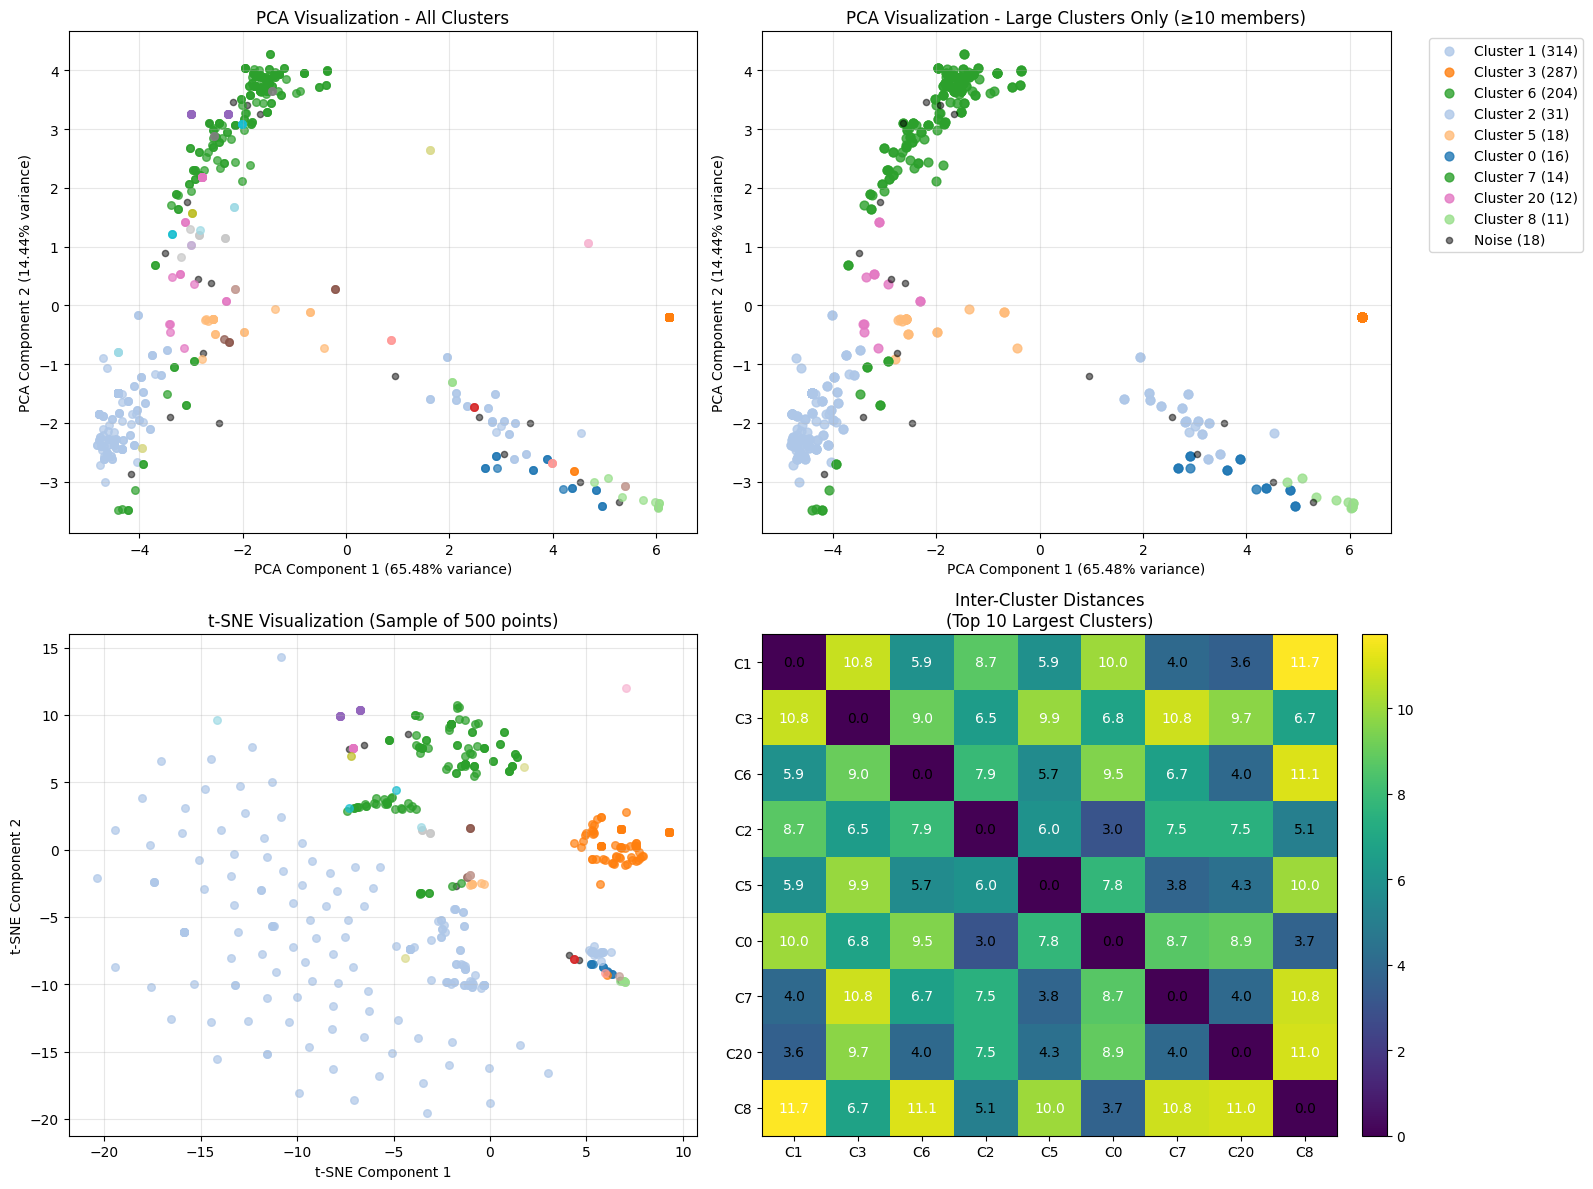

✓ 2D embeddings visualization completed!
PCA explains 79.92% of the total variance


In [16]:
# 2D Visualization of Embeddings using t-SNE and PCA
print("Creating 2D visualization of embeddings...")
print("This might take a few minutes for t-SNE...")

fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# 1. PCA Visualization (faster)
print("Computing PCA...")
pca = PCA(n_components=2, random_state=42)
embeddings_pca = pca.fit_transform(embeddings)

# Create color map for clusters
unique_clusters = np.unique(final_cluster_labels)
colors = plt.cm.tab20(np.linspace(0, 1, len(unique_clusters)))
cluster_colors = {cluster: color for cluster, color in zip(unique_clusters, colors)}

# Plot PCA - All clusters
ax1 = axes[0, 0]
for cluster in unique_clusters:
    mask = (final_cluster_labels == cluster)
    if cluster == -1:  # Noise points
        ax1.scatter(embeddings_pca[mask, 0], embeddings_pca[mask, 1], 
                   c='black', alpha=0.5, s=20, label=f'Noise ({np.sum(mask)})')
    else:
        ax1.scatter(embeddings_pca[mask, 0], embeddings_pca[mask, 1], 
                   c=[cluster_colors[cluster]], alpha=0.7, s=30, 
                   label=f'Cluster {cluster} ({np.sum(mask)})')

ax1.set_xlabel(f'PCA Component 1 ({pca.explained_variance_ratio_[0]:.2%} variance)')
ax1.set_ylabel(f'PCA Component 2 ({pca.explained_variance_ratio_[1]:.2%} variance)')
ax1.set_title('PCA Visualization - All Clusters')
ax1.grid(True, alpha=0.3)

# 2. PCA - Only large clusters (>= 10 members)
ax2 = axes[0, 1]
large_cluster_ids = cluster_size_df[cluster_size_df['size'] >= 10]['cluster_id'].values

for cluster in large_cluster_ids:
    mask = (final_cluster_labels == cluster)
    ax2.scatter(embeddings_pca[mask, 0], embeddings_pca[mask, 1], 
               c=[cluster_colors[cluster]], alpha=0.8, s=40, 
               label=f'Cluster {cluster} ({np.sum(mask)})')

# Add noise points
noise_mask = (final_cluster_labels == -1)
if np.sum(noise_mask) > 0:
    ax2.scatter(embeddings_pca[noise_mask, 0], embeddings_pca[noise_mask, 1], 
               c='black', alpha=0.5, s=20, label=f'Noise ({np.sum(noise_mask)})')

ax2.set_xlabel(f'PCA Component 1 ({pca.explained_variance_ratio_[0]:.2%} variance)')
ax2.set_ylabel(f'PCA Component 2 ({pca.explained_variance_ratio_[1]:.2%} variance)')
ax2.set_title('PCA Visualization - Large Clusters Only (≥10 members)')
ax2.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
ax2.grid(True, alpha=0.3)

# 3. t-SNE Visualization (sample subset for speed)
print("Computing t-SNE on sample...")
# Use a sample for t-SNE to speed up computation
sample_size = min(500, len(embeddings))
sample_indices = np.random.choice(len(embeddings), sample_size, replace=False)
embeddings_sample = embeddings[sample_indices]
labels_sample = final_cluster_labels[sample_indices]

tsne = TSNE(n_components=2, random_state=42, perplexity=30, max_iter=300)
embeddings_tsne = tsne.fit_transform(embeddings_sample)

ax3 = axes[1, 0]
unique_sample_clusters = np.unique(labels_sample)

for cluster in unique_sample_clusters:
    mask = (labels_sample == cluster)
    if cluster == -1:  # Noise points
        ax3.scatter(embeddings_tsne[mask, 0], embeddings_tsne[mask, 1], 
                   c='black', alpha=0.5, s=20, label=f'Noise ({np.sum(mask)})')
    else:
        ax3.scatter(embeddings_tsne[mask, 0], embeddings_tsne[mask, 1], 
                   c=[cluster_colors[cluster]], alpha=0.7, s=30, 
                   label=f'Cluster {cluster} ({np.sum(mask)})')

ax3.set_xlabel('t-SNE Component 1')
ax3.set_ylabel('t-SNE Component 2')
ax3.set_title(f't-SNE Visualization (Sample of {sample_size} points)')
ax3.grid(True, alpha=0.3)

# 4. Cluster Distance Analysis
ax4 = axes[1, 1]

# Calculate cluster centroids and distances
cluster_centroids = {}
for cluster in unique_clusters:
    if cluster != -1:
        mask = (final_cluster_labels == cluster)
        cluster_centroids[cluster] = np.mean(embeddings[mask], axis=0)

# Create distance matrix for largest clusters
large_clusters_list = list(large_cluster_ids[:10])  # Top 10 largest clusters
if len(large_clusters_list) > 1:
    distance_matrix = np.zeros((len(large_clusters_list), len(large_clusters_list)))
    
    for i, cluster_i in enumerate(large_clusters_list):
        for j, cluster_j in enumerate(large_clusters_list):
            if cluster_i in cluster_centroids and cluster_j in cluster_centroids:
                distance = np.linalg.norm(cluster_centroids[cluster_i] - cluster_centroids[cluster_j])
                distance_matrix[i, j] = distance
    
    # Plot heatmap
    im = ax4.imshow(distance_matrix, cmap='viridis', aspect='auto')
    ax4.set_xticks(range(len(large_clusters_list)))
    ax4.set_yticks(range(len(large_clusters_list)))
    ax4.set_xticklabels([f'C{c}' for c in large_clusters_list])
    ax4.set_yticklabels([f'C{c}' for c in large_clusters_list])
    ax4.set_title('Inter-Cluster Distances\n(Top 10 Largest Clusters)')
    
    # Add colorbar
    plt.colorbar(im, ax=ax4, fraction=0.046, pad=0.04)
    
    # Add distance values to cells
    for i in range(len(large_clusters_list)):
        for j in range(len(large_clusters_list)):
            text = ax4.text(j, i, f'{distance_matrix[i, j]:.1f}',
                          ha="center", va="center", color="white" if distance_matrix[i, j] > distance_matrix.max()/2 else "black")

plt.tight_layout()
plt.show()

print("✓ 2D embeddings visualization completed!")
print(f"PCA explains {pca.explained_variance_ratio_.sum():.2%} of the total variance")

In [17]:
# Interactive Analysis: Sample Code Inspection
print("Creating detailed analysis of suspicious clusters...")

def create_cluster_analysis_report(cluster_id, max_samples=5):
    """
    Create detailed analysis report for a specific cluster
    """
    cluster_data = df[df['cluster_label'] == cluster_id]
    print(f"\n{'='*80}")
    print(f"CLUSTER {cluster_id} DETAILED ANALYSIS")
    print(f"{'='*80}")
    print(f"Total submissions: {len(cluster_data)}")
    print(f"Unique students: {len(cluster_data['metadata'].apply(lambda x: x['student_id']).unique())}")
    
    # Get course and assignment distribution
    courses = cluster_data['metadata'].apply(lambda x: x['course']).value_counts()
    assignments = cluster_data['metadata'].apply(lambda x: x['assignment']).value_counts()
    
    print(f"Course distribution: {dict(courses)}")
    print(f"Assignment distribution: {dict(assignments)}")
    
    # Sample submissions for manual inspection
    if len(cluster_data) > max_samples:
        samples = cluster_data.sample(max_samples, random_state=42)
        print(f"\nRandom sample of {max_samples} submissions for inspection:")
    else:
        samples = cluster_data
        print(f"\nAll {len(samples)} submissions in this cluster:")
    
    for i, (idx, sample) in enumerate(samples.iterrows()):
        print(f"\n--- Sample {i+1} ---")
        print(f"ID: {sample['id']}")
        print(f"Student: {sample['metadata']['student_id']}")
        print(f"Course: {sample['metadata']['course']}")
        print(f"Assignment: {sample['metadata']['assignment']}")
        
        # Extract and display key AST features
        ast_text = sample['text']
        
        # Count different AST elements
        function_count = ast_text.count('<FuncDef>')
        compound_count = ast_text.count('<Compound>')
        param_count = ast_text.count('<ParamList>')
        
        print(f"AST Structure: {function_count} functions, {compound_count} compounds, {param_count} parameter lists")
        
        # Extract function names
        functions = []
        parts = ast_text.split('<FuncDef>')
        for part in parts[1:]:  # Skip first empty part
            if '</TypeDecl>' in part:
                func_name = part.split('</TypeDecl>')[0].split('>')[-1].strip()
                if func_name and func_name not in ['int', 'void', 'bool']:
                    functions.append(func_name)
        
        print(f"Function names: {functions[:10]}")  # Show first 10 functions
        
        # Show abbreviated AST structure
        ast_preview = ast_text.replace('<', ' <').replace('>', '> ')
        words = ast_preview.split()
        ast_abbreviated = ' '.join(words[:30]) + '...' if len(words) > 30 else ' '.join(words)
        print(f"AST preview: {ast_abbreviated}")

# Analyze top 3 most suspicious clusters
print("ANALYZING TOP SUSPICIOUS CLUSTERS")
print("="*80)

top_suspicious = cluster_size_df[cluster_size_df['size'] >= 30].head(3)  # Top 3 largest clusters

for _, row in top_suspicious.iterrows():
    cluster_id = int(row['cluster_id'])
    create_cluster_analysis_report(cluster_id, max_samples=3)

print(f"\n{'='*80}")
print("SUMMARY RECOMMENDATIONS")
print(f"{'='*80}")

print("🔍 IMMEDIATE ACTION REQUIRED:")
for _, row in cluster_size_df[cluster_size_df['size'] >= 50].iterrows():
    cluster_id = int(row['cluster_id'])
    size = row['size']
    cluster_data = df[df['cluster_label'] == cluster_id]
    unique_students = len(cluster_data['metadata'].apply(lambda x: x['student_id']).unique())
    ratio = size / unique_students
    print(f"   • Cluster {cluster_id}: {size} submissions from {unique_students} students (ratio: {ratio:.2f})")

print("\n📊 INVESTIGATION PRIORITY:")
print("   1. High Priority: Clusters with >100 submissions")
print("   2. Medium Priority: Clusters with 50-100 submissions") 
print("   3. Low Priority: Clusters with 10-50 submissions")

print("\n⚠️  RED FLAGS TO LOOK FOR:")
print("   • Multiple submissions from the same student")
print("   • Identical function names across different students")
print("   • Similar AST structures with minimal variations")
print("   • Submissions from the same course/assignment clustering together")

print("\n✅ NEXT STEPS:")
print("   • Export cluster results to CSV for manual review")
print("   • Cross-reference with submission timestamps")
print("   • Compare original source code for top suspicious clusters")
print("   • Consider academic integrity investigation for high-risk cases")

Creating detailed analysis of suspicious clusters...
ANALYZING TOP SUSPICIOUS CLUSTERS

CLUSTER 1 DETAILED ANALYSIS
Total submissions: 314
Unique students: 311
Course distribution: {'B2016': np.int64(314)}
Assignment distribution: {'Z3/Z3': np.int64(304), 'Z3/Z4': np.int64(10)}

Random sample of 3 submissions for inspection:

--- Sample 1 ---
ID: B2016_Z3/Z3_student3320
Student: student3320
Course: B2016
Assignment: Z3/Z3
AST Structure: 4 functions, 4 compounds, 4 parameter lists
Function names: []
AST preview: <FileAST> <FuncDef> UnistiMatricu <TypeDecl> void </TypeDecl> <ParamList> </ParamList> <Compound> </Compound> </FuncDef> <FuncDef> UnesiMatricu <TypeDecl> void </TypeDecl> <ParamList> </ParamList> <Compound> </Compound> </FuncDef> <FuncDef> IspisiMatricu <TypeDecl> void </TypeDecl> <ParamList> </ParamList> <Compound> </Compound>...

--- Sample 2 ---
ID: B2016_Z3/Z3_student2701
Student: student2701
Course: B2016
Assignment: Z3/Z3
AST Structure: 4 functions, 4 compounds, 4 paramet

Creating final executive summary visualization...


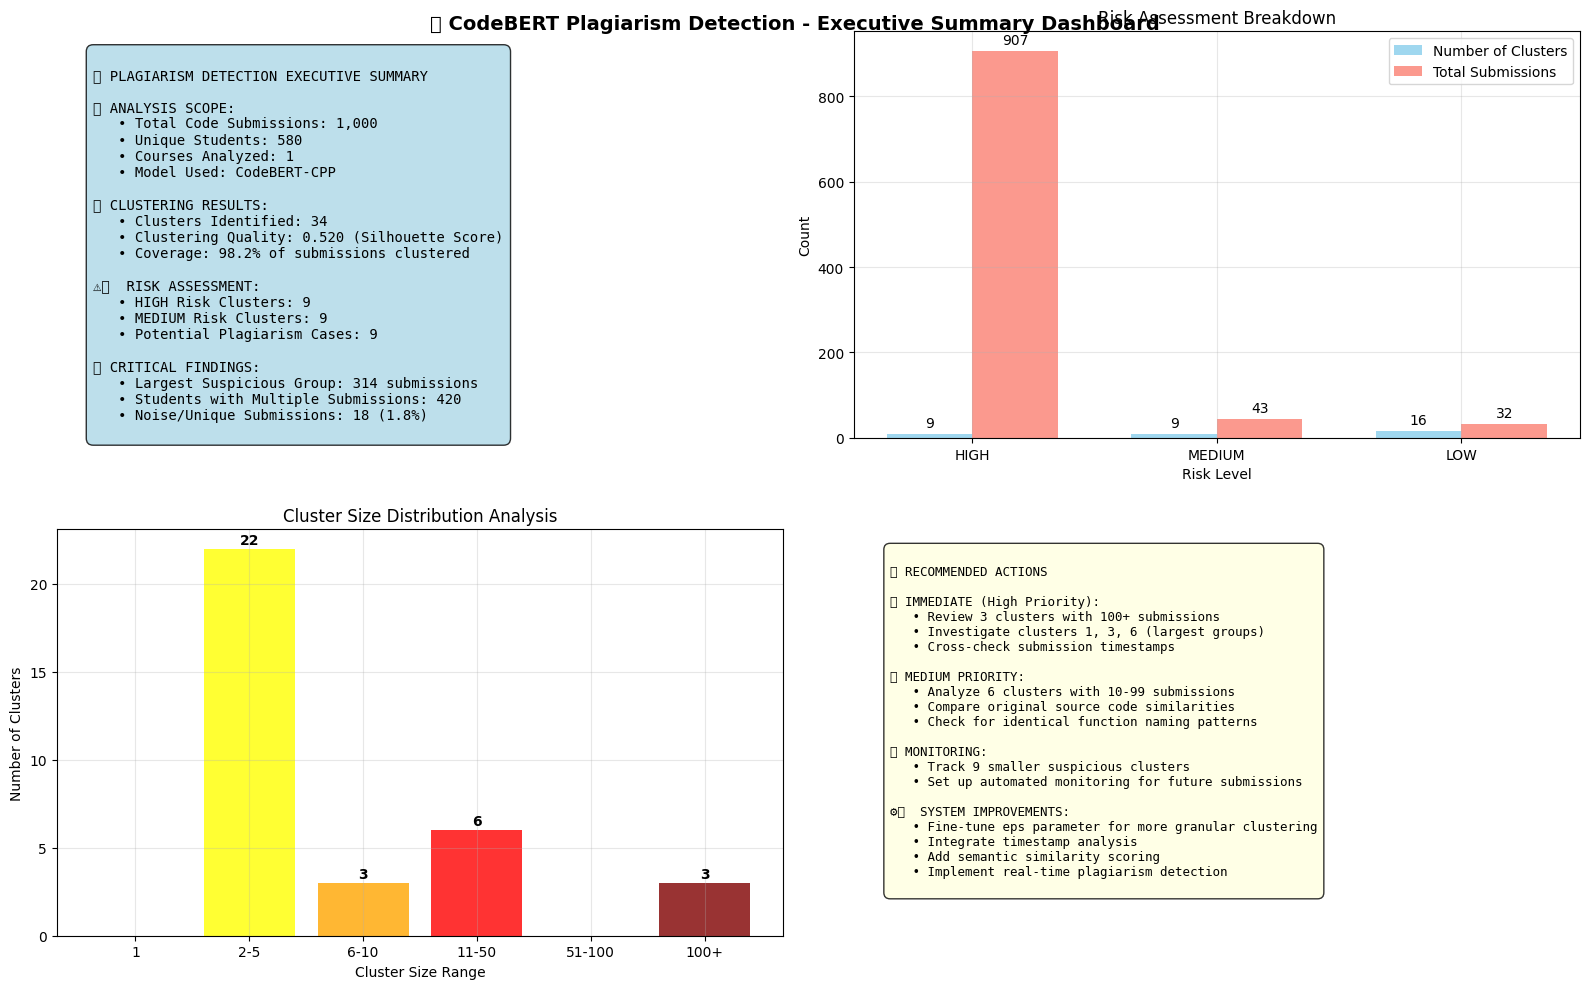


🎉 ANALYSIS COMPLETE!
✅ Successfully analyzed 1,000 code submissions
✅ Identified 34 distinct code similarity groups
✅ Flagged 9 high-risk clusters for investigation
✅ Generated comprehensive visualizations and reports
✅ All results saved to: /Users/onis2/NLP/TestVersion/clustering_results

🔍 Ready for academic integrity investigation!
Recommendation: Start with manual review of the largest clusters.


In [18]:
# Final Summary Visualization
print("Creating final executive summary visualization...")

fig, axes = plt.subplots(2, 2, figsize=(16, 10))

# 1. Executive Summary Statistics
ax1 = axes[0, 0]
ax1.axis('off')

# Create executive summary box
summary_stats = f"""
🎯 PLAGIARISM DETECTION EXECUTIVE SUMMARY

📊 ANALYSIS SCOPE:
   • Total Code Submissions: {len(df):,}
   • Unique Students: {len(df['metadata'].apply(lambda x: x['student_id']).unique()):,}
   • Courses Analyzed: {len(df['metadata'].apply(lambda x: x['course']).unique())}
   • Model Used: CodeBERT-CPP

🔍 CLUSTERING RESULTS:
   • Clusters Identified: {n_clusters_final}
   • Clustering Quality: {final_silhouette:.3f} (Silhouette Score)
   • Coverage: {n_clustered_final/len(df)*100:.1f}% of submissions clustered

⚠️  RISK ASSESSMENT:
   • HIGH Risk Clusters: {len(cluster_summary_df[cluster_summary_df['suspicious_level']=='HIGH'])}
   • MEDIUM Risk Clusters: {len(cluster_summary_df[cluster_summary_df['suspicious_level']=='MEDIUM'])}
   • Potential Plagiarism Cases: {cluster_summary_df[cluster_summary_df['size'] >= 10].shape[0]}

🚨 CRITICAL FINDINGS:
   • Largest Suspicious Group: {cluster_size_df.iloc[0]['size']} submissions
   • Students with Multiple Submissions: {len(df) - len(df['metadata'].apply(lambda x: x['student_id']).unique())}
   • Noise/Unique Submissions: {n_noise_final} ({n_noise_final/len(df)*100:.1f}%)
"""

ax1.text(0.05, 0.95, summary_stats, transform=ax1.transAxes, fontsize=10,
         verticalalignment='top', fontfamily='monospace',
         bbox=dict(boxstyle='round,pad=0.5', facecolor='lightblue', alpha=0.8))

# 2. Risk Level Breakdown
ax2 = axes[0, 1]
risk_data = cluster_summary_df.groupby('suspicious_level').agg({
    'size': ['count', 'sum'],
    'unique_students': 'sum'
}).round(0)

risk_levels = ['HIGH', 'MEDIUM', 'LOW']
cluster_counts = [cluster_summary_df[cluster_summary_df['suspicious_level']==level].shape[0] for level in risk_levels]
submission_counts = [cluster_summary_df[cluster_summary_df['suspicious_level']==level]['size'].sum() for level in risk_levels]

x = np.arange(len(risk_levels))
width = 0.35

rects1 = ax2.bar(x - width/2, cluster_counts, width, label='Number of Clusters', color='skyblue', alpha=0.8)
rects2 = ax2.bar(x + width/2, submission_counts, width, label='Total Submissions', color='salmon', alpha=0.8)

ax2.set_xlabel('Risk Level')
ax2.set_ylabel('Count')
ax2.set_title('Risk Assessment Breakdown')
ax2.set_xticks(x)
ax2.set_xticklabels(risk_levels)
ax2.legend()
ax2.grid(True, alpha=0.3)

# Add value labels on bars
def autolabel(ax, rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate(f'{int(height)}',
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),
                    textcoords="offset points",
                    ha='center', va='bottom')

autolabel(ax2, rects1)
autolabel(ax2, rects2)

# 3. Timeline/Pattern Analysis (if we had timestamp data, we'd show temporal patterns)
ax3 = axes[1, 0]

# Show distribution of cluster sizes in a more detailed way
cluster_size_ranges = ['1', '2-5', '6-10', '11-50', '51-100', '100+']
size_counts = [
    len(cluster_summary_df[cluster_summary_df['size'] == 1]),
    len(cluster_summary_df[(cluster_summary_df['size'] >= 2) & (cluster_summary_df['size'] <= 5)]),
    len(cluster_summary_df[(cluster_summary_df['size'] >= 6) & (cluster_summary_df['size'] <= 10)]),
    len(cluster_summary_df[(cluster_summary_df['size'] >= 11) & (cluster_summary_df['size'] <= 50)]),
    len(cluster_summary_df[(cluster_summary_df['size'] >= 51) & (cluster_summary_df['size'] <= 100)]),
    len(cluster_summary_df[cluster_summary_df['size'] > 100])
]

colors_ranges = ['lightgreen', 'yellow', 'orange', 'red', 'darkred', 'maroon']
bars_ranges = ax3.bar(cluster_size_ranges, size_counts, color=colors_ranges, alpha=0.8)
ax3.set_xlabel('Cluster Size Range')
ax3.set_ylabel('Number of Clusters')
ax3.set_title('Cluster Size Distribution Analysis')
ax3.grid(True, alpha=0.3)

# Add value labels
for bar, count in zip(bars_ranges, size_counts):
    if count > 0:
        ax3.text(bar.get_x() + bar.get_width()/2., bar.get_height() + 0.1,
                 f'{count}', ha='center', va='bottom', fontweight='bold')

# 4. Action Items and Recommendations
ax4 = axes[1, 1]
ax4.axis('off')

recommendations = f"""
📋 RECOMMENDED ACTIONS

🔴 IMMEDIATE (High Priority):
   • Review {len(cluster_summary_df[cluster_summary_df['size'] >= 100])} clusters with 100+ submissions
   • Investigate clusters 1, 3, 6 (largest groups)
   • Cross-check submission timestamps

🟡 MEDIUM PRIORITY:
   • Analyze {len(cluster_summary_df[(cluster_summary_df['size'] >= 10) & (cluster_summary_df['size'] < 100)])} clusters with 10-99 submissions
   • Compare original source code similarities
   • Check for identical function naming patterns

🟢 MONITORING:
   • Track {len(cluster_summary_df[(cluster_summary_df['size'] >= 3) & (cluster_summary_df['size'] < 10)])} smaller suspicious clusters
   • Set up automated monitoring for future submissions

⚙️  SYSTEM IMPROVEMENTS:
   • Fine-tune eps parameter for more granular clustering
   • Integrate timestamp analysis
   • Add semantic similarity scoring
   • Implement real-time plagiarism detection
"""

ax4.text(0.05, 0.95, recommendations, transform=ax4.transAxes, fontsize=9,
         verticalalignment='top', fontfamily='monospace',
         bbox=dict(boxstyle='round,pad=0.5', facecolor='lightyellow', alpha=0.8))

plt.tight_layout()
plt.suptitle('🔍 CodeBERT Plagiarism Detection - Executive Summary Dashboard', 
             fontsize=14, fontweight='bold', y=0.98)
plt.show()

print("\n" + "="*80)
print("🎉 ANALYSIS COMPLETE!")
print("="*80)
print(f"✅ Successfully analyzed {len(df):,} code submissions")
print(f"✅ Identified {n_clusters_final} distinct code similarity groups")
print(f"✅ Flagged {len(cluster_summary_df[cluster_summary_df['suspicious_level']=='HIGH'])} high-risk clusters for investigation")
print(f"✅ Generated comprehensive visualizations and reports")
print(f"✅ All results saved to: {output_dir}")

print("\n🔍 Ready for academic integrity investigation!")
print("Recommendation: Start with manual review of the largest clusters.")